In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
import yfinance as yf


In [ ]:
# read the csv file by selecting the path
path_file = "D:/Dropbox/Pastor/data/crypto-active_5min/BTC_5min.txt"
btc = pd.read_csv(path_file, header = None, sep = ",", names = ["Date", "Open", "High", "Low", "Close", "Volume"])
btc["Date"] = pd.to_datetime(btc['Date'])
btc.set_index('Date', inplace=True)

# set a dictionary with the variables and functions to create daily bars
ohlcv_dict = {'Open':'first', 'High':'max', 'Low':'min', 'Close': 'last', 'Volume':'sum'}

btc = btc.resample('1440Min').apply(ohlcv_dict).dropna()
btc.head()


In [61]:
spy = yf.download(tickers="SPY", auto_adjust=True)
returns_spy = spy.Close.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [67]:
#returns_spy

stock_data = pd.merge(btc, returns_spy, right_index=True, left_index=True ).sort_index()
stock_data.columns = ["Open", "High", "Low", "Close", "Volume", "returns_spy"]
returns = pd.DataFrame({
                        'stocks': stock_data['Close'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1),
                        'tbills': (stock_data['returns_spy']),
                                    }, index=stock_data.index).dropna()


In [68]:
returns.tail

<bound method NDFrame.tail of               stocks    tbills
Date                          
2013-04-02  0.174377  0.004934
2013-04-03  0.020192 -0.010139
2013-04-04  0.080733  0.004059
2013-04-05  0.054250 -0.004491
2013-04-08  0.335807  0.006767
...              ...       ...
2021-10-25  0.039479  0.005363
2021-10-26 -0.043528  0.000900
2021-10-27 -0.031194 -0.004430
2021-10-28  0.036978  0.009649
2021-10-29  0.027066  0.002029

[2157 rows x 2 columns]>

In [55]:
spy

,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29,25.735679,25.735679,25.607641,25.717388,1003200
1993-02-01,25.735667,25.900288,25.735667,25.900288,480500
1993-02-02,25.882011,25.973467,25.827137,25.955175,201300
1993-02-03,25.991755,26.247831,25.973463,26.229540,529400
1993-02-04,26.320978,26.394143,26.028320,26.339270,531500
...,...,...,...,...,...
2021-11-12,465.119995,467.859985,464.109985,467.269989,53423300
2021-11-15,468.640015,468.809998,466.230011,467.429993,46980500
2021-11-16,467.149994,470.489990,467.070007,469.279999,48857500


In [30]:
class QTrader(object):
    def __init__(self):
        
        path_file = "D:/Dropbox/Pastor/data/crypto-active_5min/BTC_5min.txt"
        btc = pd.read_csv(path_file, header = None, sep = ",", names = ["Date", "Open", "High", "Low", "Close", "Volume"])
        btc["Date"] = pd.to_datetime(btc['Date'])
        btc.set_index('Date', inplace=True)
        spy = yf.download(tickers="SPY", auto_adjust=True)
        returns_spy = spy.Close.pct_change().dropna()
      
        self.stock_data = pd.merge(btc, returns_spy, right_index=True, left_index=True ).sort_index()
        self.stock_data.columns = ["Open", "High", "Low", "Close", "Volume", "returns_spy"]
        self.returns = pd.DataFrame({
                        'stocks': self.stock_data['Close'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1),
                        'spy': (self.stock_data['returns_spy']),
                                    }, index=self.stock_data.index).dropna()

        self.returns['risk_adjusted'] = self.returns.stocks - self.returns.spy

        self.returns['risk_adjusted_moving'] = self.returns.risk_adjusted.rolling(window=12).apply(lambda x: x.mean())
        self.returns['risk_adjusted_stedv'] = self.returns.risk_adjusted.rolling(window=12).apply(lambda x: x.std())
        self.returns['risk_adjusted_high']  = self.returns.risk_adjusted_moving + 1.5 * self.returns.risk_adjusted_stedv
        self.returns['risk_adjusted_low'] = self.returns.risk_adjusted_moving - 1.5 * self.returns.risk_adjusted_stedv
        
        self.returns['state'] = (self.returns.risk_adjusted > self.returns.risk_adjusted_high).astype('int') - \
                                (self.returns.risk_adjusted < self.returns.risk_adjusted_high).astype('int')

        # 12 weeks of data
        # what's the high average
        # what's the low average
        # if the return is higher than the average high -> 1
        # if the return is lower than the average low -> -1

    def buy_and_hold(self, dates):
        return pd.Series(1, index = dates)

    def buy_spy(self, dates):
        return pd.Series(0, index = dates)

    def random(self, dates):
        return pd.Series(np.random.randint(-1, 2, size = len(dates)), index = dates)

    def calc_returns(self, holdings):
        return pd.Series(self.returns.spy + holdings * self.returns.risk_adjusted, index=holdings.index)

    def evaluate(self, holdings):
        return pd.Series(self.calc_returns(holdings) + 1).cumprod()

    def q_holdings(self, training_indexes, testing_indexes):
        factors = pd.DataFrame({'action': 0, 'reward': 0, 'state':0}, index = training_indexes)
        

        q = {0: {1:0, 0:0, -1:0}}

        for i in range(100): # this loop iterates 100 times or until convergence is reach over the training data 
            last_row, last_date = None, None

            for date, row in factors.iterrows():
                return_data = self.returns.loc[date]

                if return_data.state not in q:
                    q[return_data.state] = {1:0, 0:0, -1:0}

                if last_row is None or np.isnan(return_data.state):
                    state = 0
                    reward = 0
                    action = 0

                else:
                    state = int(return_data.state)

                    # we add randomness to the state every 0.1% of the time
                    if random.random() > 0.001:
                        action = max(q[state], key=q[state].get)
                    else:
                        action = random.randint(-1, 1)

                    reward = last_row.action * (return_data.stocks - return_data.spy)

                    factors.loc[date, 'reward'] = reward
                    factors.loc[date, 'action'] = action
                    factors.loc[date, 'state'] = return_data.state

                    alpha = 1 # can be customize, so you can try 0.0001 if you want
                    discount = 0.9

                    update = alpha * (factors.loc[date, 'reward'] + discount * max(q[row.state].values()) - q[state][action])

                    if not np.isnan(update):
                        q[state][action] += update

                    
                last_date, last_row = date, factors.loc[date]

            sharpe = self.sharpe(factors.action)

            if sharpe > 0.20:
                break

            print(f'For episode {i} we get an internal sharpe ratio of {self.sharpe(factors.action)}')

        testing = pd.DataFrame({'action': 0, 'state': 0}, index = testing_indexes)
        testing['state'] = self.returns.loc[testing_indexes, 'state']
        testing['action'] = testing['state'].apply(lambda state: max(q[state], key = q[state].get))

        return testing.action

    def sharpe(self, holdings):
        returns = holdings * (self.returns.stocks - self.returns.spy)
        return np.nanmean(returns) / np.nanstd(returns)

      
    def graph_portfolios(self):
        midpoint = int(len(self.returns.index) / 2)
        training_indexes = self.returns.index[:midpoint]
        testing_indexes = self.returns.index[midpoint:]

        portfolios = pd.DataFrame({'buy_and_hold': self.buy_and_hold(testing_indexes),
                                    'buy_spy':     self.buy_spy(testing_indexes),
                                   'random':       self.random(testing_indexes),
                                   'qtrader':      self.q_holdings(training_indexes, testing_indexes)
                                    }, index=testing_indexes)

        portfolio_values = pd.DataFrame({
            'buy_and_hold':     self.evaluate(portfolios.buy_and_hold),
            'buy_spy':          self.evaluate(portfolios.buy_spy),
            'random':           self.evaluate(portfolios.random),
            'qtrader':          self.evaluate(portfolios.qtrader)
        }, index=testing_indexes)

        portfolio_values.plot()

        plt.annotate('Buy and Hold sharpe ratio: {} \n QTrader: {}'.format(self.sharpe(portfolios.buy_and_hold), self.sharpe(portfolios.qtrader)), xy=(0.25, 0.95),
        xycoords="axes fraction")

        plt.show()
    

In [32]:
q = QTrader()


[*********************100%***********************]  1 of 1 completed


In [36]:
buy_hold = q.buy_and_hold
buy_hold

<bound method QTrader.buy_and_hold of <__main__.QTrader object at 0x0000023AC4C7D550>>

For episode 0 we get an internal sharpe ratio of 0.06365490416244422
For episode 1 we get an internal sharpe ratio of 0.0129242169350829
For episode 2 we get an internal sharpe ratio of 0.07811475038694739
For episode 3 we get an internal sharpe ratio of 0.07811475038694739
For episode 4 we get an internal sharpe ratio of 0.07253515555154887
For episode 5 we get an internal sharpe ratio of 0.17695942233544487
For episode 6 we get an internal sharpe ratio of 0.18942027143442006
For episode 7 we get an internal sharpe ratio of 0.1968830599572485
For episode 8 we get an internal sharpe ratio of 0.13054878615722376
For episode 9 we get an internal sharpe ratio of -0.024419545893111162
For episode 10 we get an internal sharpe ratio of 0.07811475038694739
For episode 11 we get an internal sharpe ratio of 0.07811475038694739
For episode 12 we get an internal sharpe ratio of 0.07811475038694739
For episode 13 we get an internal sharpe ratio of 0.104397008180181
For episode 14 we get an interna

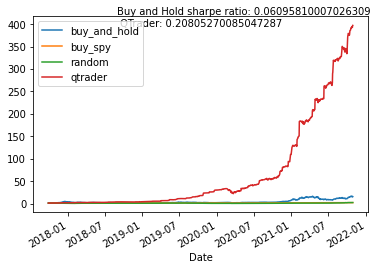

In [33]:
q.graph_portfolios()